In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from allen_v1dd.client import EMClient
from allen_v1dd.em import DynamicSynapseGraph
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups

at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")
at.set_included_mice(409828)
at.set_included_columns(1)

In [2]:
em_client = EMClient()

In [4]:
skel_features_table = em_client.query_table("cell_type_skel_features_v1")
skel_features_table.head()

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,4613,2023-05-15 04:49:48.022113+00:00,t,350562,excitatory,L2,350562,2022-02-04 06:21:10.300143+00:00,t,326.965400,94866276031228266,864691132773514104,"[894573, 478559, 163530]","[891003, 473981, 17111]","[898608, 483370, 18134]"
1,5169,2023-05-15 04:49:48.305158+00:00,t,367611,excitatory,L4,367611,2022-02-04 06:21:10.316148+00:00,t,238.028400,97474730063566602,864691132708957995,"[986529, 653935, 215865]","[981640, 650210, 22844]","[991030, 658126, 23687]"
2,6265,2023-05-15 04:49:48.860194+00:00,t,395881,excitatory,L6,395881,2022-02-04 06:21:10.353367+00:00,t,305.454529,95935482571582071,864691132928938216,"[931355, 973026, 251280]","[926311, 968370, 26631]","[936477, 976829, 27596]"
3,3413,2023-05-15 04:49:47.404515+00:00,t,291309,excitatory,L4,291309,2022-02-04 06:21:10.376628+00:00,t,252.742842,94099229098124418,864691132660524261,"[867025, 732854, 133650]","[862757, 729362, 13856]","[872069, 736734, 14885]"
4,2185,2023-05-15 04:49:46.800003+00:00,t,267573,excitatory,L3,267573,2022-02-04 06:21:10.405701+00:00,t,389.655896,91487821000913738,864691132710015275,"[776155, 451865, 387270]","[771732, 446821, 41157]","[781199, 456366, 42210]"


In [6]:
coreg_table = em_client.get_coregistration_table()
coreg_table.head()

,index,id,created,valid,target_id,session,scan_idx,unit_id,field,residual,...,ophys_volume,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,0,1,2023-04-14 22:08:40.446962+00:00,t,276266,1,3,117,1,NaN,...,3,M409828_13,0,117,M409828_13_0_117,"[778.7521791075498, 227.97907876189072, 29.657...",submitted,True,not_started,True
1,1,2,2023-04-14 22:08:40.447864+00:00,t,276140,1,3,75,1,NaN,...,3,M409828_13,0,75,M409828_13_0_75,"[816.1188928555765, 236.2662880987557, 17.5425...",submitted,True,submitted,True
2,2,3,2023-04-14 22:08:40.448713+00:00,t,290027,1,3,26,1,NaN,...,3,M409828_13,0,26,M409828_13_0_26,"[874.2243220704512, 248.26178219838565, -104.6...",not_started,False,not_started,False
3,3,4,2023-04-14 22:08:40.449580+00:00,t,365414,1,3,163,1,NaN,...,3,M409828_13,0,163,M409828_13_0_163,"[933.6856808451048, 252.00293174161231, -63.72...",not_started,False,not_started,False
4,4,5,2023-04-14 22:08:40.450423+00:00,t,365704,1,3,31,1,NaN,...,3,M409828_13,0,31,M409828_13_0_31,"[979.6986711301596, 251.2837669970616, -46.357...",not_started,False,not_started,False


In [60]:
# Compute ROI to SSI mapping
roi_to_ssi = {}
roi_to_is_responsive = {}
for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()]
    for roi in np.where(inclusion)[0]:
        roi_idx = f"{group.attrs['session_id']}_{group.attrs['plane']}_{roi}"
        if roi_idx in coreg_table.roi.values:
            roi_to_ssi[roi_idx] = group["ssi"]["ssi"][roi]
            roi_to_is_responsive[roi_idx] = group["drifting_gratings_windowed"]["frac_responsive_trials"][roi] > 0.25
    
coreg_table["ssi"] = coreg_table["roi"].apply(roi_to_ssi.get)

In [19]:
root_id_to_cell_type = pd.Series(index=skel_features_table.pt_root_id.values, data=skel_features_table.cell_type.values)
coreg_table["cell_type"] = coreg_table["pt_root_id"].apply(root_id_to_cell_type.get)

In [21]:
syn_graph_filename = f"/Users/chase/Desktop/v1dd_v{em_client.version}_synapses.gpl"
syn_graph = DynamicSynapseGraph(em_client, filename=syn_graph_filename)

Loading graph from file /Users/chase/Desktop/v1dd_v376_synapses.gpl


In [61]:
# Preload all synapses
pt_root_ids = coreg_table.pt_root_id.values
# pt_root_ids = coreg_table.pt_root_id.values
syn_graph.get_dendritic_synapses(pt_root_ids)

There are 60 neurons that need loaded den synapses.
  Loading den synapses for 8 neurons (52 remaining)
  Loading den synapses for 8 neurons (44 remaining)
  Loading den synapses for 8 neurons (36 remaining)
  Loading den synapses for 8 neurons (28 remaining)
  Loading den synapses for 8 neurons (20 remaining)
  Loading den synapses for 8 neurons (12 remaining)
  Loading den synapses for 8 neurons (4 remaining)
  Loading den synapses for 4 neurons


,pre_pt_root_id,post_pt_root_id,size,soma_soma_dist,soma_soma_dist_horiz,syn_pre_soma_dist_straight,syn_post_soma_dist_straight
0,864691132724164721,864691132827688641,657,79.141963,68.136127,115.199313,54.927389
1,864691132724164721,864691132827688641,569,79.141963,68.136127,79.644642,4.766556
2,864691132724164721,864691132827688641,747,79.141963,68.136127,80.971989,4.611654
3,864691132724164721,864691132827688641,325,79.141963,68.136127,103.188834,24.838909
4,864691132724164721,864691132827688641,454,79.141963,68.136127,65.112421,46.041667
...,...,...,...,...,...,...,...
543460,864691132641378102,864691132736082347,4561,316.546734,275.260938,272.527283,97.949718
543461,864691132863019002,864691132736082347,3982,NaN,NaN,NaN,50.076603
543462,864691132180489590,864691132736082347,5414,NaN,NaN,NaN,41.494973
543463,864691132538572439,864691132736082347,750,NaN,NaN,NaN,103.993122


In [62]:
df = []

for row in coreg_table[coreg_table.pt_root_id.isin(pt_root_ids)].itertuples():
    root_id = row.pt_root_id
    pre_syn = syn_graph.get_dendritic_synapses(root_id)

    if len(pre_syn) == 0:
        print(f"No pre synapses for {root_id}")
        continue

    entry = dict(
        root_id = root_id,
        ssi = row.ssi,
        n_pre = len(pre_syn)
    )

    for pre_cell_type, pre_count in pre_syn.pre_pt_root_id.apply(root_id_to_cell_type.get).value_counts(dropna=False).items():
        entry[f"n_pre_{pre_cell_type}"] = pre_count

    df.append(entry)
    
df = pd.DataFrame(df)
df.fillna(0, inplace=True)
df = df.convert_dtypes()
df.head()

There are 1 neurons that need loaded den synapses.
  Loading den synapses for 1 neurons
No pre synapses for 864691132669357329
No pre synapses for 864691132589862744


,root_id,ssi,n_pre,n_pre_None,n_pre_DistTC,n_pre_ProxTC,n_pre_L3,n_pre_L4,n_pre_L2,n_pre_SparTC,n_pre_InhTC,n_pre_L5,n_pre_L6,n_pre_L5ET,n_pre_L5NP
0,864691132827688641,-0.009724,3787,3503,120,115,26,10,6,3,1,1,1,1,0
1,864691132728579766,0.76206,3436,3165,111,117,21,9,3,2,6,1,0,1,0
2,864691132727393198,-0.858749,3151,3050,38,36,12,6,2,1,3,2,1,0,0
3,864691132782526604,0.525628,3831,3711,42,57,8,8,2,0,1,2,0,0,0
4,864691132715818816,0.460345,2558,2474,33,41,5,3,0,1,0,1,0,0,0


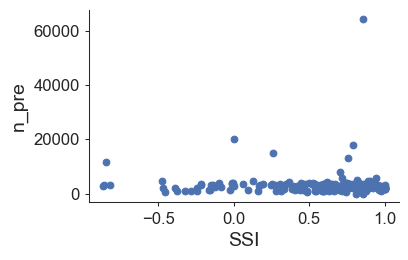

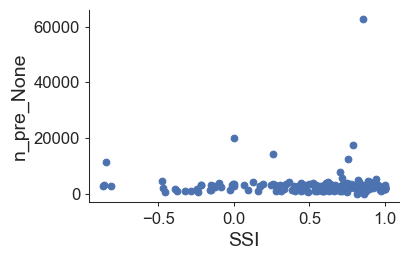

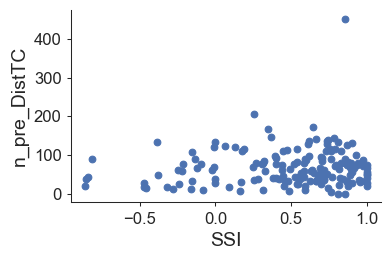

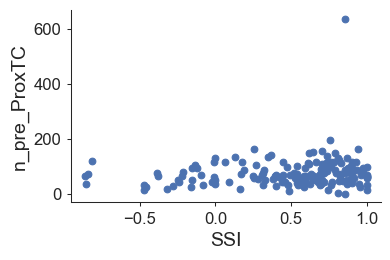

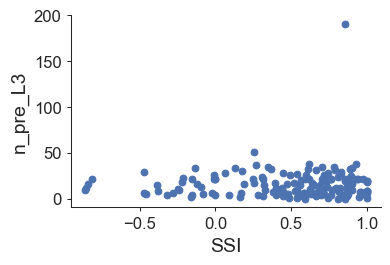

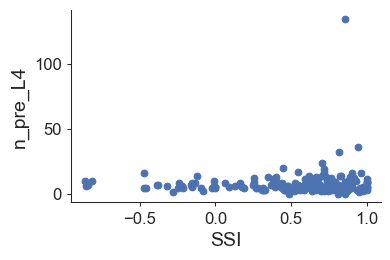

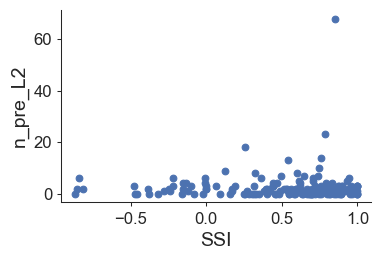

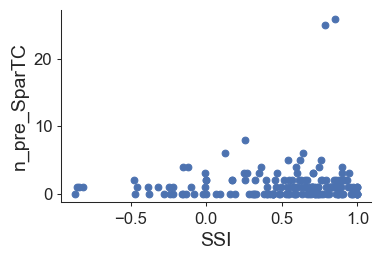

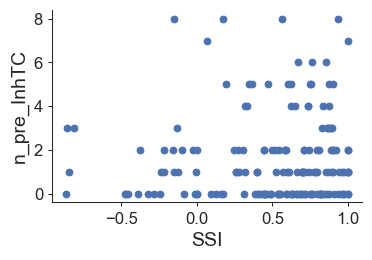

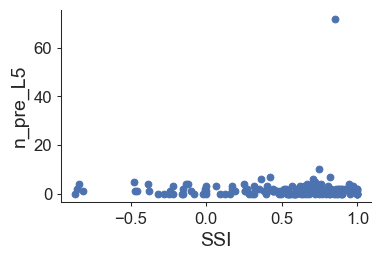

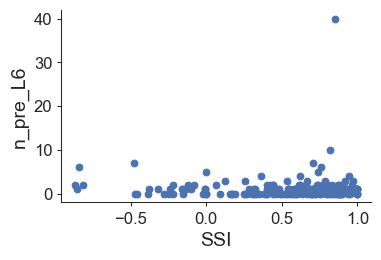

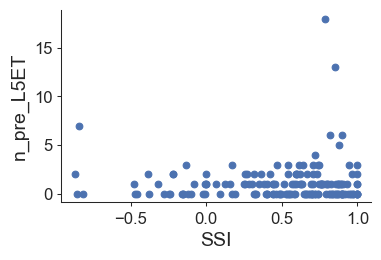

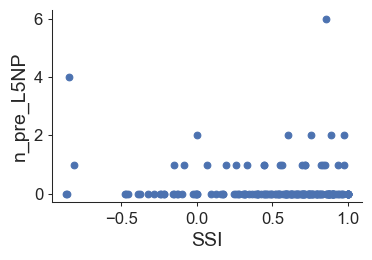

In [64]:
for col in df.columns[2:]:
    fig, ax = plt.subplots(figsize=(4, 2.5))
    ax.scatter(df.ssi, df[col])
    ax.set_xlabel("SSI")
    ax.set_ylabel(col)